# NOAA Coral Reef Watch's CoralTemp: Dataset Overview and Use Case Example
## CRCM-Science - Using the CoralTemp Dataset for Climate Resilient Coral Modeling (CRCM)
## EDS 220, Fall 2021

The following Jupyter notebook demonstrates key features and use case examples for the NOAA Coral Reef Watch CoralTemp dataset.

## Authors

- Alex Clippinger, Bren School of Environmental Science & Management, (alexclippinger@ucsb.edu) 
- Charles Hendrickson, Bren School of Environmental Science & Management, (c_d_h@ucsb.edu)
- Connor Flynn, Bren School of Environmental Science & Management, (connorflynn@ucsb.edu)

## Table of Contents

[1. Purpose](#purpose)

[2. Dataset Description](#overview)

[3. Metadata](#display)

[4. Data I/O](#io)

[5. Basic Visualization](#viz)

[6. Use Case Examples](#usecases)

[7. Bonus SARIMA Forecasting](#forecasting)

[8. Binder Environment](#binder)

[9. References](#references)

<a id='purpose'></a> 
## Purpose

This notebook was created to provide an introduction to the NOAA Coral Reef Watch CoralTemp data products, specifically the 5-km sea surface temperature dataset, although we will also introduce the sea surface temperature anomaly and degree heating week datasets. We will demonstrate the capability of using the sea surface temperature data product to analyze climate change's potential impact on heat resilient coral relative to normal coral.

<a id='overview'></a> 
## Dataset Description

#### Creators of the dataset

The CoralTemp data products are maintained by NOAA's Coral Reef Watch Organization (CRW). CRW was established in 2000 to address the need to enhance coral reef resilience. Since then, the organization has accurately monitored and predicted all major bleaching events since 1997. The CoralTemp dataset is the foundation of Coral Reef Watch's ability to fulfill their mission of protecting coral reefs.

#### Major characteristics

CoralTemp is a global sea surface temperature data product used primarily for coral bleaching monitoring. The dataset contains many data products based on 5 geostationary and 3 polar-orbiting satellites. These products include the main sea surface temperature data set (which is the basis for the other products), degree heating week (DHW), bleaching alert areas, coral bleaching hotspots, sea ice fraction, and sea surface temperature anomaly.

NOAA satellite data sets have specified processing levels ranging from 0 to 4, with 0 indicating unprocessed telemetry data as received and 4 indicating data products that are model output or results from analysis derived from multiple measurements. The CoralTemp SST product is derived from three level-4 satellite datasets:
  - NOAA/NESDIS operational near-real-time daily global 5-km geostationary-polar-orbiting (geo-polar) blended night-only SST analysis
  - NOAA/NESDIS 2002-2016 reprocessed daily global 5-km geo-polar blended night-only SST analysis
  - United Kingdom Met Office 1985-2002 daily global 5-km night-only SST reanalysis of Operational SST and Sea Ice Analysis (OSTIA)

Thus, the data is gridded and gap-filled according to NOAA’s highest processing level. Therefore, there are no significant gaps in data, spatially or temporally, and all outliers and spikes are likely reflective of real world occurrences.

Source: https://coralreefwatch.noaa.gov/product/5km/tutorial/crw05a_sst_product.php

- Description of data products referenced further:
  - SST: Nighttime sea surface temperature (celsius), calibrated to 0.2 meters depth, across the entire globe.
    - Nighttime measurements reduces the influence of solar heating during the day near the sea surface and avoid solar glare contamination. Also water temperatures at night at and near the sea surface are more vertically uniform. Therefore, it is a more stable estimate of heat stress on coral bleaching.
  - SST Anomaly: A comparison of current sea surface temperature with the long-term daily mean climatology at a given location during a certain period of time.
    - The temperature anomalies range from -5.0 to +5.0 degrees Celsius (°C). Data and images are updated daily.
  - Degree Heating Week - The DHW shows how much heat stress (SST above the bleaching threshold) has accumulated in an area in the last 12 weeks.
    - The units for DHW are "degree Celsius-weeks" (or °C-weeks), combining the intensity and duration of the oceanic heat stress into a single number.
    - For example, a DHW of 2 is equivalent to one week of 2 °C heat stress (temperature above bleaching threshold), or two weeks at 1 °C, etc.
  - Bleaching Alert Area - Summary of areas with potential coral bleaching
    - 5 levels
      - No stress (Negative SST anomaly)
      - Bleaching warning (SST anomaly between 0 and 1) 
      - Bleaching watch (SST anomaly above 1 and DHW between 0 and 4)
      - Alert level 1 (SST anomaly above 1 and DHW between 4 and 8)
      - Alert level 2 (SST anomaly above 1 and DHW greater than 8)
    
We will focus on the primary sea surface temperature (SST) dataset for the remainder of the notebook. The key details of the SST dataset include: 
- Spatial Resolution: 5km gridded cells.
- Spatial Coverage: The dataset has a complete spatial coverage of the ocean. 
- Temporal Resolution: 1985-04-01 to present. 

#### File format(s)

Data can be downloaded as CSV, netCDF, geotiff, and other common file formats with some unique limitations. For example, geotiff downloads can only contain a single day of data. CSV downloads on the other hand can contain multiple days of observations in a single file. The data is produced daily in near real-time, with an approximately 60 hour delay in availability from the present.

A detailed list of output formats can be found in the data product documentation here: https://coastwatch.pfeg.noaa.gov/erddap/griddap/documentation.html

#### Source/Archive

The data can be accessed via a REST API data access form. Here is the URL for manually querying the data: https://coastwatch.pfeg.noaa.gov/erddap/griddap/NOAA_DHW.html

This data source is maintained by the creator of the dataset, NOAA, indicating that this should be a reliable source of data for the foreseeable future.

#### Known issues with data quality

There are limitations associated with using the dataset, which has a 5-km grid resolution and once-daily measurements. Although sufficient for numerous useful applications, this spatial scale may not be high enough for certain applications, such as drawing conclusions on variation in sea surface temperature within a small area such as a coral reef. Ocean sea surface temperature varies continuously across the surface, not in gridded cells, which could introduce an inherent bias in our analysis. In addition, ocean temperature varies consistently over time, while the dataset only contains a single nighttime reading per day.

<a id='display'></a> 
## Metadata

A complete list of variables and attributes, as well as their descriptions, are provided on the Data Access Form used to download CoralTemp data products. Additionally, information like the publisher name, email, and institution is provided, as well as an overall summary of the dataset, specific products, and output file formats. Information about key variables such as time, latitude, longitude, and their associated mask is extensively documented in the metadata. 

For example, 

  - Data Access Form/output format documentation: https://coastwatch.pfeg.noaa.gov/erddap/griddap/documentation.html
  - Detailed Metadata on all CoralTemp data products: https://coastwatch.pfeg.noaa.gov/erddap/info/NOAA_DHW/index.html

<a id='io'></a> 
## Dataset Input/Output 

The following code chunks demonstrate how to read in CoralTemp data for analysis using the REST API query.

#### Import all necessary packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

#### Set parameters

Later, in our use case example, we will be examining a specific coral reef in Honoli'i, HI. In the parameters below, we set the bounding box to only include the cell containing this location. We chose 2019 as an arbitrary year to demonstrate the seasonality of the sea surface temperature data over an entire year.

In [2]:
# Set parameters used in data access query
start_date = '2019-01-01T12:00:00Z'
end_date = '2019-12-31T12:00:00Z'
product_code = 'SST'
output_format = 'csv'

# Bounding box for our area of interest - Honoli'i, HI
ymax = '19.800'
ymin = '19.750'
xmin = '-155.099'
xmax = '-155.050'

#### Load CoralTemp data

The following code block shows the URL used to pull data from the data server and how it can be filled in using the parameters from the previous chunk. Since we read the data in csv format, it is easily transformed into a pandas dataframe.

In [3]:
# Query to pull data from Coral Reef Watch data products
base_url = 'https://coastwatch.pfeg.noaa.gov/erddap/griddap/NOAA_DHW.'
query = base_url+output_format+'?CRW_'+product_code+'%5B('+start_date+'):1:('+end_date+')%5D%5B('+ymax+'):1:('+ymin+')%5D%5B('+xmin+'):1:('+xmax+')%5D'

# Read csv
df = pd.read_csv(query, 
                 names = ["date", "latitude", "longitude", "sst_c"], 
                 skiprows = 2)

# Remove timestamp and set date as index
df["date"] = pd.to_datetime(df["date"])

# Show preview of dataset
df.head()

,date,latitude,longitude,sst_c
0,2019-01-01 12:00:00+00:00,19.775,-155.075,24.86
1,2019-01-02 12:00:00+00:00,19.775,-155.075,24.97
2,2019-01-03 12:00:00+00:00,19.775,-155.075,24.94
3,2019-01-04 12:00:00+00:00,19.775,-155.075,24.92
4,2019-01-05 12:00:00+00:00,19.775,-155.075,24.77


<a id='viz'></a> 
## Basic Visualization

The following code chunk is a basic visualization of the 2019 SST dataset loaded in the previous two steps using standard matplotlib functions. We observe that SST measurements are highest during the summer months.

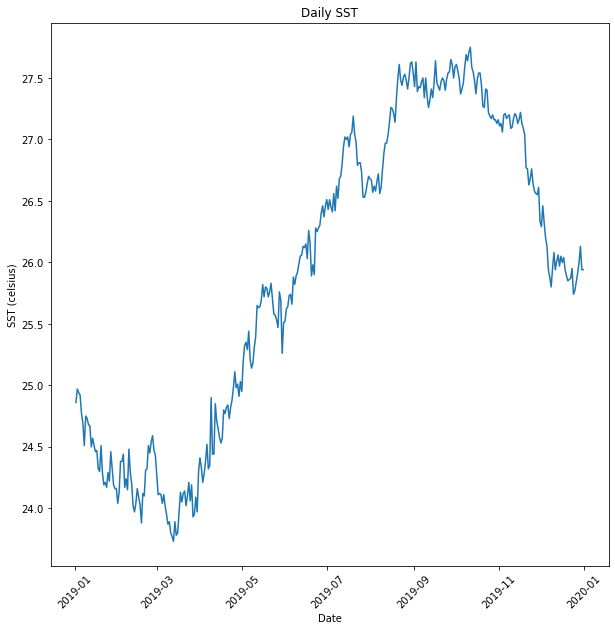

In [4]:
# Create basic time-series
fig, ax = plt.subplots(figsize = (10, 10))
ax.plot(df["date"],
        df["sst_c"])
ax.set(xlabel = "Date",
       ylabel = "SST (celsius)",
       title = "Daily SST")
plt.setp(ax.get_xticklabels(), rotation = 45)
plt.show()

<a id='usecases'></a> 
## Use Case Example - Climate Resilient Coral Modeling

#### Summary

Our team will demonstrate the ability to use the CoralTemp dataset to analyze heat resilient coral and the effects of rising sea surface temperatures on coral bleaching. Additionally, we will use the CoralTemp dataset to forcast future bleaching events for both heat tolerant and non-heat tolerant corals. We will focus on a gridded cell containing a reef known to have heat tolerant coral, located in Honoli'i (near Hilo, Hawai'i). Coral can be heat tolerant for a variety of reasons. This analysis relies on the hypothesis that the coral of Honolii reef have the ability to adapt to heat by hosting a symbiont algae that increases their bleaching threshold by approximately 1.5 degree celsius compared to non heat tolerant coral. **Our hypothesis will be implemented by calculating a new bleaching threshhold that will use an increased heat tolerance of 1.5 degree celsius.** 

As previously mentioned, the CoralTemp suite of data products are oriented towards coral reef monitoring. Primarily, the datasets are used to study and predict bleaching events and hot spots. Thus, our analysis extends on this applicability to forecasting the impact of sea surface warming on coral reefs. The target audience for this example are Coral Reef Managers and individuals interested in reef resilience. This concept can be applied to predict future reef heat tolerance in any location and guide outplanting operations to maintain reefs with longer-term heat tolerance.

Here is where the coral reef is located. We will be using SST data for the gridded cell containing this area:

![](./images/image.png)
![](./images/reef_location.png)

The steps of the analysis include:

**1. Load in the entire CoralTemp SST dataset (1985-Present)**

**2. Use the existing dataset to forecast SST to 2030**

**3. Calculate and visualize degree heating week**

#### Walkthrough

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import datetime

**1. Load in the entire CoralTemp SST dataset (1985-Present)**

The SST data was downloaded in three year increments from the data server. In order for the data to be loaded faster, the following for loop combines the three year increments into a single csv that will be used in our analysis. 

In [6]:
# Create empty dataframe
sst_df = pd.DataFrame()

# Append all data into single dataframe
for f in glob.glob("data/*.csv"):
    df = pd.read_csv(f,
                     usecols = [0,3],
                     names = ["date", "sst_c"], 
                     skiprows = 2)
    sst_df = sst_df.append(df, ignore_index = True)

# Change date column from str to datetime and make it the index
sst_df['date'] = pd.to_datetime(sst_df['date'])
sst_df = sst_df.set_index(['date'])

sst_df.tail()

,sst_c
date,
2021-11-05 12:00:00+00:00,25.77
2021-11-06 12:00:00+00:00,25.79
2021-11-07 12:00:00+00:00,25.67
2021-11-08 12:00:00+00:00,25.57
2021-11-09 12:00:00+00:00,25.75


**2. Use the existing dataset to forecast SST to 2030**

For our first forecasting method we assume a constant increase in SST by 0.2 degrees Celsius per year. The purpose of this forecast is to show the difference in DHW between heat tolerant and non-heat tolerant corals. The following code chunk shows how to calculate SST until 2030 using 2015 as a base year. 

In [7]:
# Create "training" dataset - in this simple example, we are just using the year prior
sst_df_training = sst_df['2015-01-01 12:00:00+00:00':'2015-12-31 12:00:00+00:00']

# Create empty dataframe
sst_df_forecast = pd.DataFrame(columns = ['date', 'sst_c'])

# Add date range to date column
sst_df_forecast['date'] = pd.date_range(start = '2021-11-10 12:00:00+00:00', end = '2030-11-09 12:00:00+00:00')

# change date column from str to datetime and make it the index
sst_df_forecast['date'] = pd.to_datetime(sst_df_forecast['date'])
sst_df_forecast = sst_df_forecast.set_index(['date'])

# remove leap days
sst_df_forecast = sst_df_forecast[~((sst_df_forecast.index.month == 2) & (sst_df_forecast.index.day == 29))]

# Get list of years to be forecast
forecasted_years = sst_df_forecast.index.year.unique().to_numpy()[:-1]

# Iterate through years and apply basic yearly increase in SST
for year in forecasted_years:
    year_index = np.where(forecasted_years == year)[0][0]
    yearly_sst_increase = 0.2
    sst_df_forecast[str(year)+'-11-10 12:00:00+00:00':str(year+1)+'-11-09 12:00:00+00:00'] = sst_df_training + (year_index*yearly_sst_increase)
    
sst_df_forecast.head()

,sst_c
date,
2021-11-10 12:00:00+00:00,24.7
2021-11-11 12:00:00+00:00,24.71
2021-11-12 12:00:00+00:00,24.83
2021-11-13 12:00:00+00:00,24.63
2021-11-14 12:00:00+00:00,24.44


This code chunk visualizes our forecasted SST. 

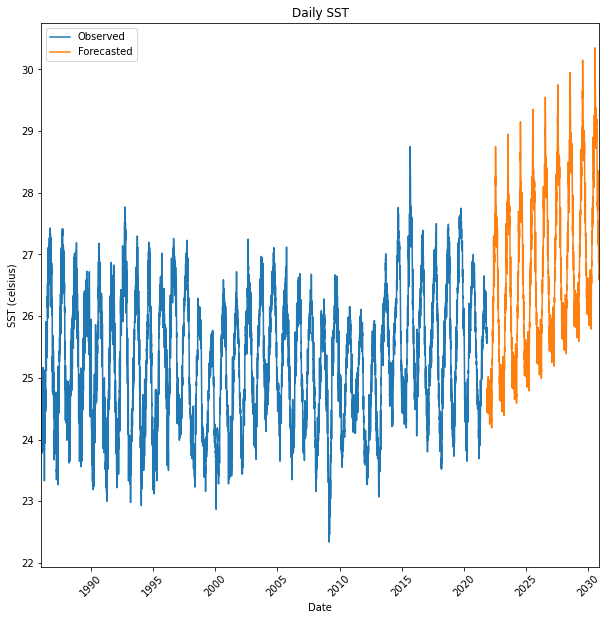

In [8]:
## Create time-series of forecasted SST values
fig, ax = plt.subplots(figsize = (10, 10))
ax.plot(sst_df.index,
        sst_df["sst_c"],
        label = "Observed")

ax.plot(sst_df_forecast.index,
        sst_df_forecast["sst_c"],
        label = "Forecasted")

ax.legend()

ax.set(xlabel = "Date",
       ylabel = "SST (celsius)",
       title = "Daily SST")

ax.set_xlim(left = datetime.date(1986, 1, 1), right = datetime.date(2030, 11, 9))

plt.setp(ax.get_xticklabels(), rotation = 45)
plt.show()

**3. Calculate bleaching thresholds and visualize degree heating week**

First, we need to calculate our bleaching thresholds. This threshold was identified by scientists in the 1980s, who found that corals experience stress if water reaches 1°C warmer than the highest expected annual temperature (Glynn and D'Croz, 1990). Thus, the **bleaching threshold** is defined as **1°C warmer than the long term max monthly mean temperature**.

The long-term daily means can be derived from the SST and SST anomaly data products. The SST anomaly is the difference of SST compared to the daily long term mean SST. In the code below, **we use SST and SST anomaly data for 2019 to find the long term means**, which allow us to calculate the bleaching threshold for our specific reef location. An alternative method would be to find the monthly mean SST. 

This first code chunk loads in 2019 SST anomaly data.

In [9]:
# Set parameters used in REST API query
start_date = '2019-01-01T12:00:00Z'
end_date = '2019-12-31T12:00:00Z'
product_code = 'SSTANOMALY'
output_format = 'csv'

ymax = '19.800'
ymin = '19.750'
xmin = '-155.099'
xmax = '-155.050'

# Query to pull data from Coral Reef Watch data products
query = r'https://coastwatch.pfeg.noaa.gov/erddap/griddap/NOAA_DHW.'+output_format+'?CRW_'+product_code+'%5B('+start_date+'):1:('+end_date+')%5D%5B('+ymax+'):1:('+ymin+')%5D%5B('+xmin+'):1:('+xmax+')%5D'

# Read csv
df_anomaly = pd.read_csv(query, 
                         usecols = [0,3],
                         names = ["date", "sst_anomaly"], 
                         skiprows = 2)

# Remove timestamp
df_anomaly["date"] = pd.to_datetime(df_anomaly["date"])


This second code chunk finds the average monthly mean in order to calculate the bleaching thresholds. 

In [10]:
# Load SST data for 2019
df = sst_df['2019-01-01T12:00:00Z':'2019-12-31T12:00:00Z']
df = df.reset_index()

# Calculate long-term daily mean based on anomaly dataset
df_anomaly["monthly_mean_sst"] = df['sst_c'] - df_anomaly['sst_anomaly']

# Find average monthly mean
df_month = df_anomaly.groupby(df_anomaly["date"].dt.strftime('%B'))['monthly_mean_sst'].mean().sort_values()

# Set bleaching thresholds according to max monthly mean
bleaching_threshold = df_month.max() + 1
bleaching_threshold_ht = bleaching_threshold + 1.5

print("Normal bleaching threshold: " + str(round(bleaching_threshold, 2)))
print("Heat tolerant bleaching threshold: " + str(round(bleaching_threshold_ht, 2)))

Normal bleaching threshold: 27.62
Heat tolerant bleaching threshold: 29.12


Next, we calculate the **degree heating week** (DHW). Here is NOAA's definition of this metric from the metadata: "The DHW value at any particular location at any particular time is the summation of SST anomaly values which are at least 1 deg C above the bleaching threshold SST and their durations in weeks over the most recent 12-week period."

In [11]:
## Calculate degree heating week

# Combine observed and forecasted data
heat_stress_df = pd.concat([sst_df, sst_df_forecast], axis = 0)

# Create columns showing daily heat stress
heat_stress_df["above_threshold"] = np.where(heat_stress_df['sst_c'] - bleaching_threshold <= 0, 0, heat_stress_df['sst_c'] - bleaching_threshold)
heat_stress_df["above_threshold_ht"] = np.where(heat_stress_df['sst_c'] - bleaching_threshold_ht <= 0, 0, heat_stress_df['sst_c'] - bleaching_threshold_ht)

# Calculate degree heating week (cumulative heat stress)
heat_stress_df['dhw'] = heat_stress_df['above_threshold'].rolling(min_periods=1, window=84).sum()/7
heat_stress_df['dhw_ht'] = heat_stress_df['above_threshold_ht'].rolling(min_periods=1, window=84).sum()/7

heat_stress_df

,sst_c,above_threshold,above_threshold_ht,dhw,dhw_ht
date,,,,,
1985-11-09 12:00:00+00:00,25.45,0,0,0.000000,0.000000
1985-11-10 12:00:00+00:00,25.56,0,0,0.000000,0.000000
1985-11-11 12:00:00+00:00,25.7,0,0,0.000000,0.000000
1985-11-12 12:00:00+00:00,25.87,0,0,0.000000,0.000000
1985-11-13 12:00:00+00:00,26.02,0,0,0.000000,0.000000
...,...,...,...,...,...
2030-11-05 12:00:00+00:00,26.89,0,0,7.772571,0.045143
2030-11-06 12:00:00+00:00,26.82,0,0,7.615333,0.045143
2030-11-07 12:00:00+00:00,26.65,0,0,7.410952,0.045143


Lastly, we can visualize SST and Degree Heating Week for our forecasted years. We see a significant difference in DHW between non-heat tolerant corals and heat tolerant corals. 

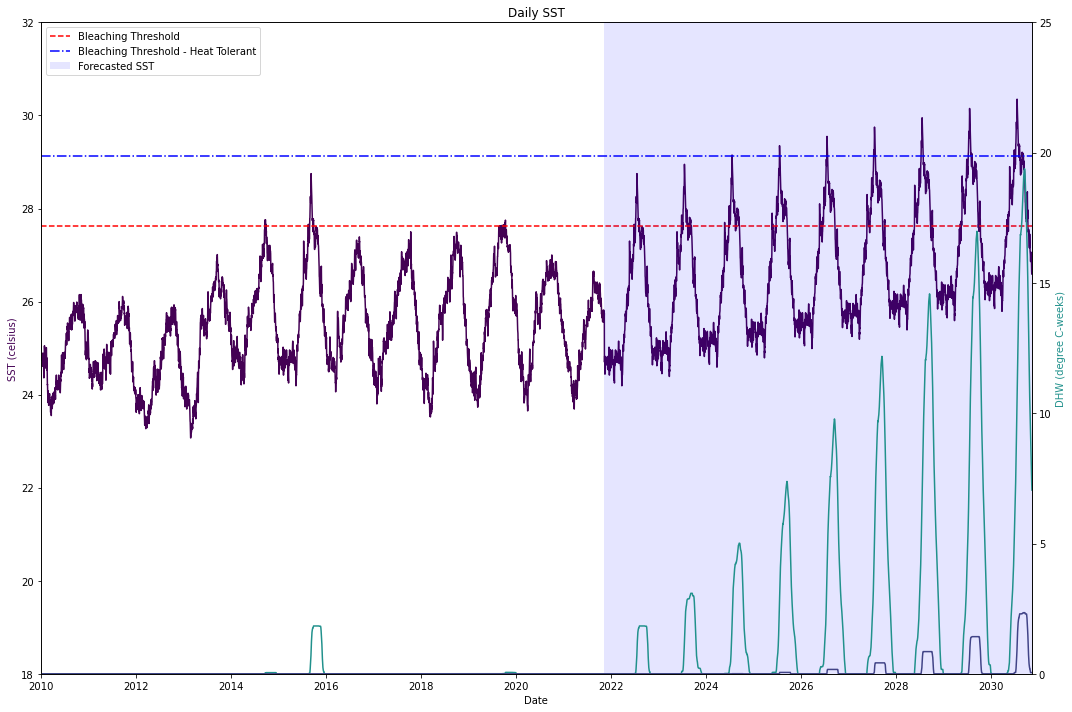

In [12]:
## SOURCE: https://stackoverflow.com/questions/9103166/multiple-axis-in-matplotlib-with-different-scales

fig, ax = plt.subplots(figsize=(15,10))
    
dhw = ax.twinx()
    
ax.set_xlim(left = datetime.date(2010, 1, 1), right = datetime.date(2030, 11, 9))
ax.set_ylim(18, 32)
dhw.set_ylim(0, 25)
    
ax.set(xlabel = "Date",
       ylabel = "SST (celsius)",
       title = "SST and DHW")
dhw.set_ylabel("DHW (degree C-weeks)")

ax.set(xlabel = "Date",
       ylabel = "SST (celsius)",
       title = "Daily SST")

sst_plot, = ax.plot(heat_stress_df.index, 
                    heat_stress_df['sst_c'], 
                    color = plt.cm.viridis(0), 
                    label = "SST (C)")

dhw_plot, = dhw.plot(heat_stress_df.index, 
                     heat_stress_df['dhw'], 
                     color = plt.cm.viridis(0.5), 
                     label = "DHW (degree C-weeks)")

dhw_ht_plot, = dhw.plot(heat_stress_df.index, 
                        heat_stress_df['dhw_ht'], 
                        color = plt.cm.viridis(0.2), 
                        label = "Heat Tolerant DHW (degree C-weeks)")

bleaching = ax.axhline(y = bleaching_threshold, 
                       color = "red", 
                       linestyle = '--',
                       label = "Bleaching Threshold")

bleaching_ht = ax.axhline(y = bleaching_threshold_ht, 
                          color = "blue", 
                          linestyle = '-.',
                          label = "Bleaching Threshold - Heat Tolerant")

forecast = plt.axvspan(datetime.date(2021, 11, 9), datetime.date(2030, 11, 9), facecolor='b', alpha=0.1, label = "Forecasted SST")

ax.legend(handles = [bleaching, bleaching_ht, forecast], loc='upper left')

ax.yaxis.label.set_color(sst_plot.get_color())
dhw.yaxis.label.set_color(dhw_plot.get_color())

fig.tight_layout()

plt.savefig("sst_dhw.pdf")

#### Discussion of results

As we can see in the plot above, the increased heat tolerance of certain coral species drastically decreases their likelihood of bleaching and mortality. For instance in 2015, the most extreme bleaching event in recent history resulted in a 2.5 DHW for non heat tolerant corals. However, heat tolerant corals did not undergo any heat stress. Since our forecast demonstrates increasing warming scenarios (by 0.2 degrees Celsius per year), we can see that once daily SST rises by 0.8 degrees, heat stress begins to effect heat tolerant corals. 

Further, this analysis could be extended to look at other reefs with known major bleaching events (for example, the 2016-2017 bleaching events impacting the Great Barrier Reef) and visualizing the potential increased tolerance and impact on heat tolerant coral species.

Clearly, applying a linear increase in sea surface temperature to a single year of data is not an accurate representation of future SST. Local sea surface temperature year to year is impacted greatly by El Nino/La Nina events and other factors. This non-linear change in SST can be seen from our observed data from 1985-Present. Therefore, we continue our analysis by utilizing the SARIMA forecasting model to predict future SST. 



 

<a id='forecasting'></a> 
## Bonus SARIMA Forecasting

First, we need to load in these additional packages.

In [13]:
# New packages
import warnings
import itertools
import statsmodels.api as sm
import pmdarima as pm
from pylab import rcParams

Next, using our full SST dataset from previous sections, we resample from daily to monthly mean measurements. This allows for easier forecasting given that we need to account for monthly seasonal trends and drastically reduces computation time.

<AxesSubplot:xlabel='date'>

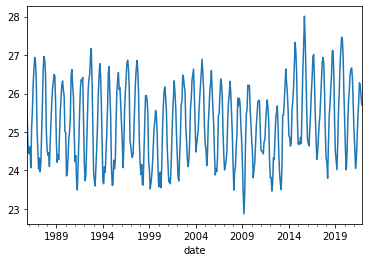

In [14]:
# SST data resampled to monthly means to make forecasting more approachable
sst_month_avg = sst_df['sst_c'].resample('MS').mean()

sst_month_avg.plot()

### Visualize Trends

The decomposition plot shows the primary components of our time-series data. We can see the overall, seasonal, and residual trends. It is evident that seasonal variation is the primary driver of SST change over time.

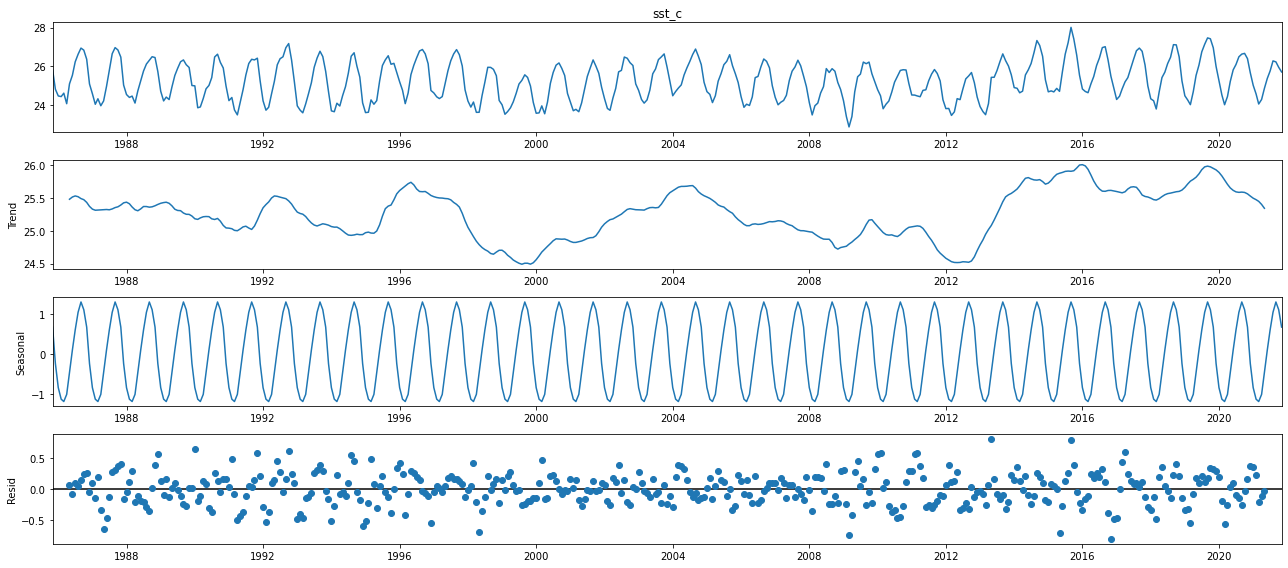

In [15]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(sst_month_avg, model='additive')
fig = decomposition.plot()
plt.show()

Next, we show the autocorrelation of our time-series data. This plot again demonstrates the clear seasonal trend that we are observing. Data with a lag of 12 months have a high positive correlation with present data and data with a lag of 6 months have a high negative correlation. This is due to consistent seasonal temperature fluctuations.

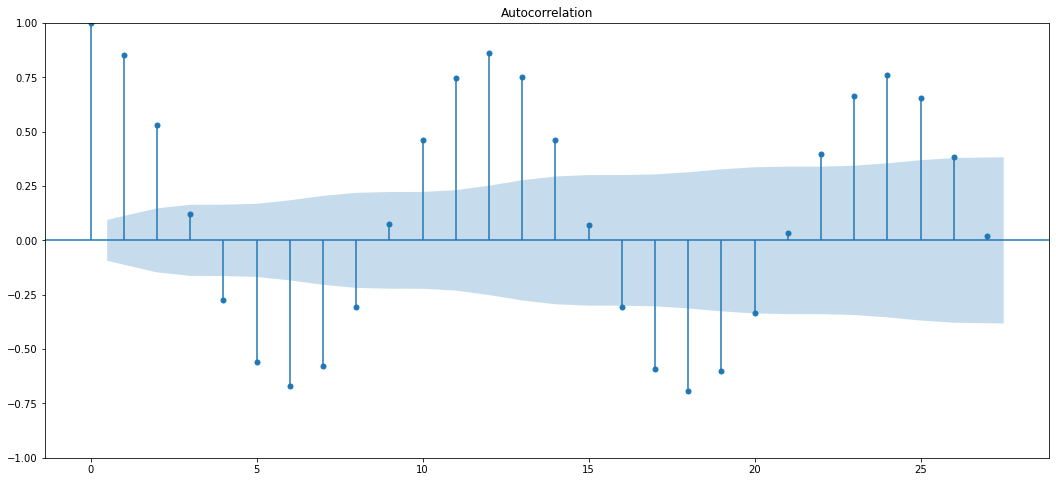

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(sst_month_avg)
plt.show()

### SARIMA Model

There are numerous forecasting methods and selecting the most "accurate" method is often the primary question that a research study aims to address. Due to limited time, we only test and implement a **Seasonal Auto-Regressive Integrated Moving Average** (SARIMA) model. We chose this model because it is highly popular for modeling time-series data with a seasonality component.

The following code chunk demonstrates the importance of selecting the parameters for our SARIMA model, which is a complex task requiring significant knowledge of the model and data. Below, we show a sample of parameter choices and their corresponding Akaike information criterion (AIC), which is an estimator of model prediction error (thus, theoretically the lower the AIC, the better the model).

In [30]:
warnings.filterwarnings("ignore")

p = range(0, 2)
d = range(0, 1) # Limited range to display quicker
q = range(0, 1) # Limited range to display quicker
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(sst_month_avg,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:4018.463250442299
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:598.4304714093298
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:703.3682601730756
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:284.53862378112944


Out of our sample parameter choices below, we would select the fourth option because we observe the lowest AIC. Instead of manually identifying the parameters for our SARIMA model, we instead will use `auto_arima`, which is a function in the `pmdarima` package that automates the selection of parameters.

In [39]:
mod = pm.auto_arima(sst_month_avg, m = 12, trace = True, error_action = 'ignore', suppress_warnings = True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=573.810, Time=3.28 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1230.768, Time=0.11 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=1.94 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=586.450, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=4027.804, Time=0.02 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=286.423, Time=2.22 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=324.507, Time=1.17 sec
 ARIMA(2,0,2)(0,0,2)[12] intercept   : AIC=286.969, Time=4.20 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=530.450, Time=2.44 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=282.943, Time=4.96 sec
 ARIMA(2,0,2)(2,0,2)[12] intercept   : AIC=241.764, Time=5.21 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=inf, Time=5.79 sec
 ARIMA(1,0,2)(2,0,2)[12] intercept   : AIC=inf, Time=4.81 sec
 ARIMA(2,0,1)(2,0,2)[12] intercept   : AIC=284.392, Time=4.53 sec
 ARIMA(3,0,2)(2,0,2)[12] intercept   : AIC=

With `trace = True`, we see that `auto_arima` performs a similar operation as before. Now, using the selected parameters, we run the SARIMA model and display the results.

In [41]:
mod = sm.tsa.statespace.SARIMAX(sst_month_avg,
                                order=(2,0,5),
                                seasonal_order=(0,0,2,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8660      0.104     17.936      0.000       1.662       2.070
ar.L2         -0.8660      0.104     -8.324      0.000      -1.070      -0.662
ma.L1         -0.9044      0.225     -4.027      0.000      -1.345      -0.464
ma.L2         -0.2135      0.062     -3.432      0.001      -0.335      -0.092
ma.L3         -0.0318      0.080     -0.399      0.690      -0.188       0.124
ma.L4          0.0255      0.088      0.290      0.772      -0.147       0.198
ma.L5          0.1246      0.075      1.658      0.097      -0.023       0.272
ma.S.L12       1.9817      0.212      9.364      0.000       1.567       2.397
ma.S.L24       2.7832      0.359      7.745      0.000       2.079       3.488
sigma2         0.0165      0.005      3.123      0.002       0.006       0.027


Further, we can visualize some diagnostic plots of the results.

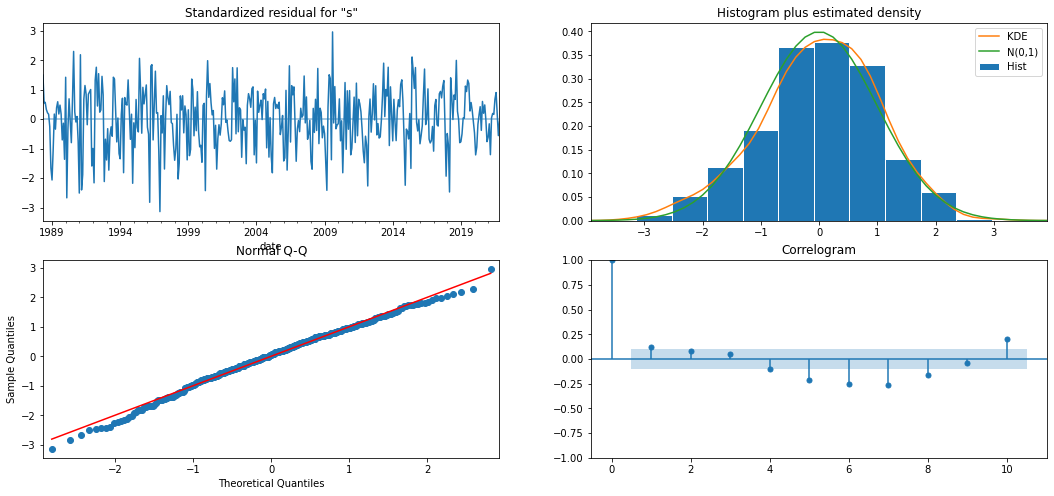

In [42]:
results.plot_diagnostics(figsize=(18,8))
plt.show()

Next, the model results are used to forecast values. The plot below demonstrates predicted and observed SST from 2015 to present.

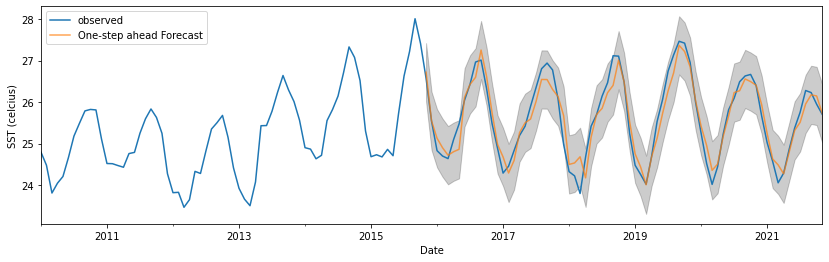

In [61]:
start = '2015-11-01 00:00:00+00:00'

pred = results.get_prediction(start=pd.to_datetime(start), dynamic=False)

pred_ci = pred.conf_int()

ax = sst_month_avg['2010':].plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('SST (celcius)')
plt.legend()
plt.show()

The mean squared error and root mean squared error can be used to determine the accuracy of predictions. In this case, our error is relatively low.

In [62]:
y_forecasted = pred.predicted_mean
y_truth = sst_month_avg[start:]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 0.08
The Root Mean Squared Error is 0.29


Lastly, we forecast future values for the next two years.

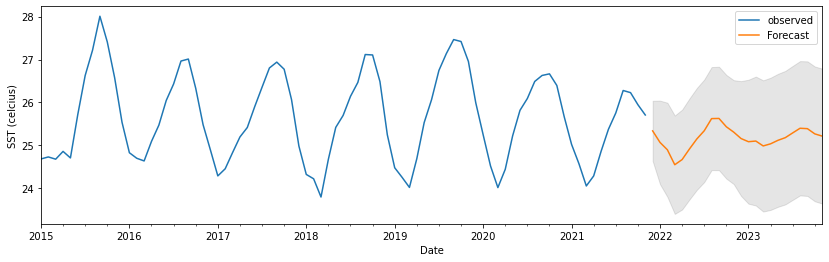

In [63]:
pred_uc = results.get_forecast(steps=24)
pred_ci = pred_uc.conf_int()
ax = sst_month_avg['2015':].plot(label='observed', figsize=(14, 4))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.1)
ax.set_xlabel('Date')
ax.set_ylabel('SST (celcius)')
plt.legend()
plt.show()

### Conclusion

Currently, the model does not appear to have the same degree of seasonal variation as observed years. Further mastery in time-series forecasting combined with domain expertise in Sea Surface Temperature datasets is needed to accurately integrate a forecasting model such as `SARIMA` into our analysis. However, the techniques as shown above are approachable even for fledgling data scientists such as ourselves.

<a id='binder'></a> 
## Binder Environment

Our Binder environment can be found at the following link: https://mybinder.org/v2/gh/crcm-science/HW3_crcm-science/HEAD

<a id='references'></a> 
## References

1. “NOAA Coral Reef Watch Tutorial.” Accessed November 19, 2021. https://coralreefwatch.noaa.gov/product/5km/tutorial/welcome.php.

2. Coles, Steve L., Keisha D. Bahr, Ku’ulei S. Rodgers, Stacie L. May, Ashley E. McGowan, Anita Tsang, Josh Bumgarner, and Ji Hoon Han. “Evidence of Acclimatization or Adaptation in Hawaiian Corals to Higher Ocean Temperatures.” PeerJ 6 (August 7, 2018): e5347. https://doi.org/10.7717/peerj.5347.

